In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras import backend

from model.data_loader import *
from model.data_loader_old import *
from model.unet_baseline import *
from model.unet_zhixuhao import *
from model.unet_ternaus import *

In [43]:
train_pth = 'data/membrane/train'
test_pth = 'data/membrane/test'
results_pth = 'results/'

In [64]:
def fast_test(model_fn, train_loader, test_loader, iterations, train_steps, val_steps, epochs=1, lr=1e-4):
    hists = []
    for i in range(iterations):
        model = model_fn(input_size=(256, 256, 1))
        model.compile(optimizer = Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit_generator(train_loader, steps_per_epoch=train_steps, epochs=1,
                                      validation_data=test_loader, validation_steps=val_steps)
        hists.append(history.history)
        backend.clear_session()
    return hists

def hists2df(hists:list):
    df = pd.DataFrame(columns=hists[0].keys())
    for h in hists:
        r = {k: h[k][-1] for k in h}
        df = df.append(r, ignore_index=True)
    return df

## Data loader

In [65]:
train_loader = loader(train_pth, input_generator_train, target_generator_train)
test_loader = loader(test_pth, input_generator_test, target_generator_test)

In [67]:
hists_zhixuhao = fast_test(unet, train_loader, test_loader, 5, 50, 100, epochs=1, lr=1e-4)
df_zhixuhao = hists2df(hists_zhixuhao)

Epoch 1/1
50/50 [==============================] - 16s 315ms/step - loss: 0.9708 - acc: 0.7583 - val_loss: 0.8132 - val_acc: 0.7984
Epoch 1/1
48/50 [===========================>..] - ETA: 0s - loss: 1.3856 - acc: 0.7548

KeyboardInterrupt: 

In [63]:
df_zhixuhao

,val_loss,val_acc,loss,acc
0,0.675608,0.864123,0.901470,0.802952
1,0.663937,0.798072,0.903146,0.765860
2,1.383410,0.797002,1.395992,0.763659
3,0.655923,0.845466,0.914337,0.777305
4,0.688071,0.796446,0.911334,0.767824


# Fast test

## Compare baseline implementation to zhixuhao's model

It is observed that the final accuracy of both models varies in the range 80-96% when trained for 5 epochs with 2000 iterations. How can we quickly compare the performance of these two models?

Here's a quick comparison of models by training each for 50 iterations from scratch 30 times. We compare our baseline implementation to [zhixuhao's model](https://github.com/zhixuhao/unet) and find no significant difference.

In [18]:
hists_zhixuhao = fast_test(unet_zhixuhao, 30, 50, epochs=1, lr=1e-4)
df_zhixuhao = hists2df(hists_zhixuhao)

Epoch 1/1
50/50 [==============================] - 12s 232ms/step - loss: 0.8322 - acc: 0.8077
Epoch 1/1
50/50 [==============================] - 12s 232ms/step - loss: 0.7661 - acc: 0.8168
Epoch 1/1
50/50 [==============================] - 12s 235ms/step - loss: 0.8373 - acc: 0.8045
Epoch 1/1
50/50 [==============================] - 11s 227ms/step - loss: 1.3986 - acc: 0.7481
Epoch 1/1
50/50 [==============================] - 12s 232ms/step - loss: 1.0304 - acc: 0.7696
Epoch 1/1
50/50 [==============================] - 12s 233ms/step - loss: 1.0034 - acc: 0.7668
Epoch 1/1
50/50 [==============================] - 12s 235ms/step - loss: 0.8602 - acc: 0.7770
Epoch 1/1
50/50 [==============================] - 12s 234ms/step - loss: 0.9069 - acc: 0.7997
Epoch 1/1
50/50 [==============================] - 11s 229ms/step - loss: 1.3861 - acc: 0.7665
Epoch 1/1
50/50 [==============================] - 12s 234ms/step - loss: 0.7629 - acc: 0.8170
Epoch 1/1
50/50 [==============================] -

In [34]:
hists_baseline = fast_test(unet, 30, 50, epochs=1, lr=1e-4)
df_baseline = hists2df(hists_baseline)

Epoch 1/1
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
50/50 [==============================] - 12s 241ms/step - loss: 1.0472 - acc: 0.7676
Epoch 1/1
50/50 [==============================] - 11s 230ms/step - loss: 0.9031 - acc: 0.7792
Epoch 1/1
50/50 [==============================] - 11s 227ms/step - loss: 1.3849 - acc: 0.7728
Epoch 1/1
50/50 [==============================] - 11s 228ms/step - loss: 0.8677 - acc: 0.7781
Epoch 1/1
50/50 [==============================] - 12s 233ms/step - loss: 0.9722 - acc: 0.7671
Epoch 1/1
50/50 [==============================] - 12s 233ms/step - loss: 1.3902 - acc: 0.7641
Epoch 1/1
50/50 [==============================] - 12s 238ms/step - loss: 0.9063 - acc: 0.7700
Epoch 1/1
50/50 [==============================] - 12s 242ms/step - loss: 1.4092 - acc: 0.7530
Epoch 1/1
50/50 [==============================] - 11s 230ms/step - loss: 0.9981 - acc: 0.7813
Epoch 1/1
50/50 [==============================] - 12s 230ms/step

In [130]:
def stats(df):
    mean = df['acc'].mean()
    upper = mean + df['acc'].std()
    lower = mean - df['acc'].std()
    return mean, upper, lower

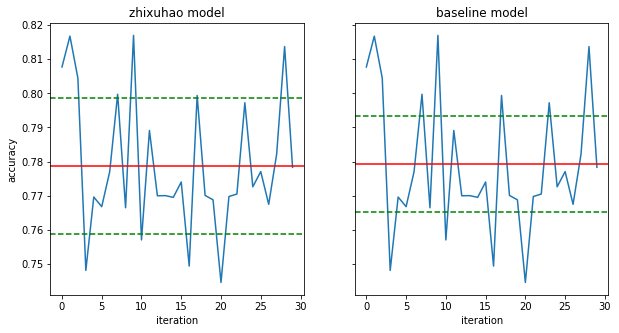

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

mean, upper, lower = stats(df_zhixuhao)
ax1.set_title('zhixuhao model')
ax1.plot(list(df_zhixuhao.index), list(df_zhixuhao['acc']))
ax1.axhline(y=mean, color='r')
ax1.axhline(y=upper, linestyle='--', color='g')
ax1.axhline(y=lower, linestyle='--', color='g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy')

mean, upper, lower = stats(df_baseline)
ax2.set_title('baseline model')
ax2.plot(list(df_baseline.index), list(df_zhixuhao['acc']))
ax2.axhline(y=mean, color='r')
ax2.axhline(y=upper, linestyle='--', color='g')
ax2.axhline(y=lower, linestyle='--', color='g')
ax2.set_xlabel('iteration');


In [129]:
hists_ternaus = fast_test(ternausNet16, 30, 50, epochs=1, lr=1e-4)
df_ternaus = hists2df(hists_ternaus)

Epoch 1/1
50/50 [==============================] - 15s 297ms/step - loss: 0.7050 - acc: 0.8593
Epoch 1/1
50/50 [==============================] - 15s 291ms/step - loss: 0.6396 - acc: 0.8626
Epoch 1/1
50/50 [==============================] - 14s 283ms/step - loss: 0.8894 - acc: 0.8131
Epoch 1/1
50/50 [==============================] - 14s 283ms/step - loss: 1.0406 - acc: 0.8396
Epoch 1/1
50/50 [==============================] - 14s 282ms/step - loss: 0.7748 - acc: 0.8505
Epoch 1/1
50/50 [==============================] - 14s 279ms/step - loss: 1.1600 - acc: 0.8080
Epoch 1/1
50/50 [==============================] - 14s 283ms/step - loss: 1.2755 - acc: 0.7870
Epoch 1/1
50/50 [==============================] - 14s 289ms/step - loss: 0.9349 - acc: 0.8293
Epoch 1/1
50/50 [==============================] - 14s 284ms/step - loss: 0.7109 - acc: 0.8554
Epoch 1/1
50/50 [==============================] - 14s 286ms/step - loss: 0.9228 - acc: 0.8220
Epoch 1/1
50/50 [==============================] -

Text(0, 0.5, 'accuracy')

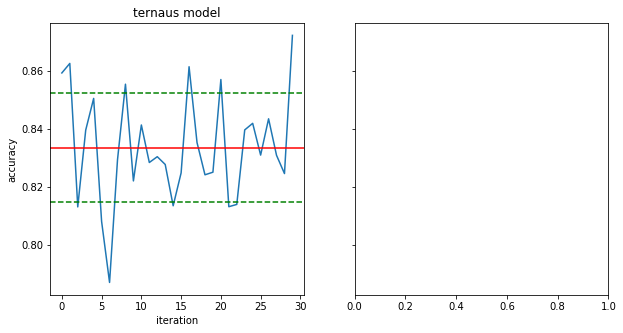

In [131]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

mean, upper, lower = stats(df_ternaus)
ax1.set_title('ternaus model')
ax1.plot(list(df_ternaus.index), list(df_ternaus['acc']))
ax1.axhline(y=mean, color='r')
ax1.axhline(y=upper, linestyle='--', color='g')
ax1.axhline(y=lower, linestyle='--', color='g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy')

# Slow test

In [85]:
hists_zhixuhao_slow = fast_test(unet_zhixuhao, 10, 1000, epochs=1, lr=1e-4)
hists_baseline_slow = fast_test(unet, 10, 1000, epochs=1, lr=1e-4)

Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 1.3618 - acc: 0.7804
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5108 - acc: 0.8934
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5411 - acc: 0.8715
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.7130 - acc: 0.8497
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.4790 - acc: 0.8942
Epoch 1/1
1000/1000 [==============================] - 190s 190ms/step - loss: 0.5763 - acc: 0.8883
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5646 - acc: 0.8913
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5737 - acc: 0.8881
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5536 - acc: 0.8961
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5516 - acc: 0.8968


In [ ]:
df_zhixuhao_slow = hists2df(hists_zhixuhao_slow)
df_baseline_slow = hists2df(hists_baseline_slow)

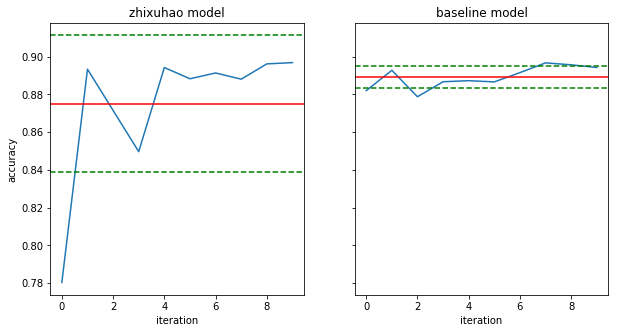

In [88]:
def stats(df):
    mean = df['acc'].mean()
    upper = mean + df['acc'].std()
    lower = mean - df['acc'].std()
    return mean, upper, lower

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

mean, upper, lower = stats(df_zhixuhao_slow)
ax1.set_title('zhixuhao model')
ax1.plot(list(df_zhixuhao_slow.index), list(df_zhixuhao_slow['acc']))
ax1.axhline(y=mean, color='r')
ax1.axhline(y=upper, linestyle='--', color='g')
ax1.axhline(y=lower, linestyle='--', color='g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy')

mean, upper, lower = stats(df_baseline_slow)
ax2.set_title('baseline model')
ax2.plot(list(df_baseline_slow.index), list(df_baseline_slow['acc']))
ax2.axhline(y=mean, color='r')
ax2.axhline(y=upper, linestyle='--', color='g')
ax2.axhline(y=lower, linestyle='--', color='g')
ax2.set_xlabel('iteration');

In [124]:
hists_ternaus_slow = fast_test(ternausNet16, 10, 1000, epochs=1, lr=1e-4)

NameError: name 'ternausNet16' is not defined

## Ternaus Net

In [99]:
model = ternausNet16(input_size=(256, 256, 1))

In [101]:
model.compile(optimizer = Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
history = model.fit_generator(train_gen, steps_per_epoch=2000, epochs=5)

Epoch 1/5
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
2000/2000 [==============================] - 409s 205ms/step - loss: 0.3079 - acc: 0.9330
Epoch 2/5
2000/2000 [==============================] - 404s 202ms/step - loss: 0.1859 - acc: 0.9594
Epoch 3/5
2000/2000 [==============================] - 404s 202ms/step - loss: 0.1514 - acc: 0.9670
Epoch 4/5
2000/2000 [==============================] - 403s 202ms/step - loss: 0.1338 - acc: 0.9708
Epoch 5/5
2000/2000 [==============================] - 403s 201ms/step - loss: 0.1219 - acc: 0.9734


In [122]:
ternaus_2000_5_df = pd.DataFrame(history.history)
ternaus_file = f'{results_pth}ternaus_2000_5.csv'
ternaus_2000_5_df.to_csv(ternaus_file)

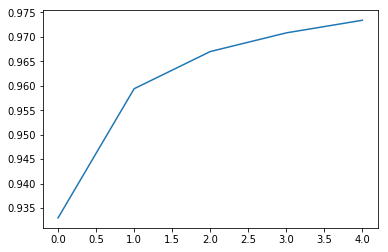

In [123]:
df = pd.read_csv(ternaus_file)
x = df.index
plt.plot(x, df['acc']);